In [1]:
import pandas as pd
import numpy as np
import json
from scipy.sparse import hstack
import time
from collections import Counter
from sklearn.preprocessing.data import OneHotEncoder
from sklearn import preprocessing
import gc
import umap.umap_ as umap
import os
from gensim.models import Word2Vec
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import warnings;
warnings.filterwarnings('ignore')
import json


UsageError: Line magic function `%matplotlib inline` not found.


In [12]:
data_test_df = pd.DataFrame(columns=['distinct_id','keyword','time'])
for i in range(1,51):
    file_name = '/Users/wjj/Desktop/jupyte/food_recommender/data/0308/%s.csv'%i
    if os.path.exists(file_name):
        data_tmp_df = pd.read_csv(file_name,header=0)
        data_test_df = pd.concat([data_tmp_df,data_test_df],axis=0)
    else:
        print(i)
del data_tmp_df;gc.collect()

In [15]:
data_test_df['time'] = [pd.Timestamp(time) for time in data_test_df['time'].values]
data_test_df['time'] = data_test_df['time'].apply(lambda x: '%s-%s-%s'%(x.year,x.month,x.day))
data_test_df = data_test_df.drop_duplicates(['distinct_id','keyword','time'])
data_test_df['keyword']=data_test_df['keyword'].astype(str)

KeyboardInterrupt: 

In [ ]:
data_test_df = data_test_df.sort_values(by=['distinct_id','time'],ascending=True) 

In [ ]:
data_test_df = data_test_df[['distinct_id','keyword']].groupby(['distinct_id']).apply(lambda x: x['keyword'].tolist()).reset_index()             

In [ ]:
data_test_df.rename(columns={0:'keyword'},inplace=True)

In [ ]:
data_test_df

In [ ]:
data_test_df=data_test_df.sort_values(by=['distinct_id','time'],ascending=True) 
data_test_df = data_test_df[['distinct_id','keyword']].groupby(['distinct_id']).apply(lambda x: x['keyword'].tolist()).reset_index()             
data_test_df.rename(columns={0:'keyword'},inplace=True)

In [19]:
train_data_list = data_test_df['keyword'].tolist()

In [20]:
model = Word2Vec(window = 5, sg = 1, hs = 0,negative = 10,alpha=0.03, min_alpha=0.0007,seed = 14)
model.build_vocab(train_data_list,progress_per=200)
model.train(train_data_list,total_examples=model.corpus_count,epochs=10,report_delay=1)

(889493056, 2102498200)

In [21]:
X = model[model.wv.vocab]
X.shape

/Users/wjj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


(5571, 100)

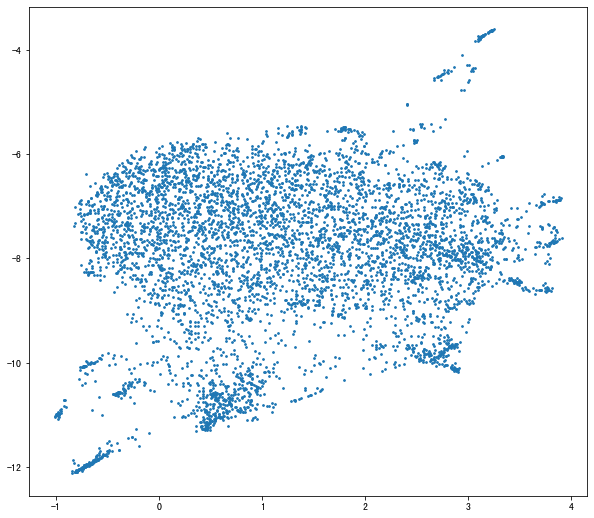

In [22]:
cluster_embedding=umap.UMAP(n_neighbors=30,min_dist=0.0,n_components=2,random_state=42).fit_transform(X)
plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:,0],cluster_embedding[:,1],s=3,cmap='Spectral')

In [23]:
def similar_products(v,n=100):
    ms=model.similar_by_vector(v,topn=n+1)[1:]
    new_ms=[]
    for j in ms:
        pair=(j[0][0],j[1])
        new_ms.append(pair)
    return new_ms

In [37]:
def recommder(input_word): 
    input_word_list = []
    #input_word = ['鱼','青菜','韭菜']
    stop_words_list = ['水','方便面','稀饭','粥','油','面','脆肉皖','脆肉鲩','雨','挂面','汤圆','元宵','面条','米饭','汤圆','白开水','菜','肉','汤','人造肉','橘子','草莓','砂糖橘','龙虾排','泡面','火锅','漫画','辣条','薯片','砂糖桔','桔子','白昼','车厘子','小橘子','橙子','白饭','巧克力','奶茶','糖果','沙糖桔','可乐','雪碧','皇帝柑']
    for i in input_word:
        tmp_list = [s for s in i]
        input_word_list.extend(tmp_list) 
    #food_recommend_df = pd.DataFrame(columns=["food", "similarity"])
    food_recommend_df = pd.DataFrame(model.predict_output_word(context_words_list=input_word,topn=500), columns=["food", "similarity"])
    #return_list = model.predict_output_word(context_words_list=input_word,topn=50)
    result_dict = {}
    for index,row in food_recommend_df.iterrows():
        list_1 = [row[0].find(y) for y in input_word_list]
        if sum(list_1) == len(list_1)*(-1) and row[0] not in stop_words_list:
            result_dict[row[0]]=round(row[1],8)*100
    return result_dict


In [1]:
#防止泄密就把结果注释啦
#recommder(['牛奶'])

In [2]:
 #model.wv.most_similar(positive=['啤酒'], negative = None,topn=50)

In [9]:
def recommder(input_word): 
    with open('/Users/wjj/Desktop/jupyter/food_recommender/data/stop_words_2.pk', 'rb') as f:
        stop_words_list = pickle.load(f)
    input_word_list =[]
    for i in input_word:
        tmp_list = [s for s in i]
        input_word_list.extend(tmp_list)
    model = Word2Vec.load("/Users/wjj/Desktop/jupyter/food_recommender/model/word2vec_0330_9000w.model")
    food_recommend_df = pd.DataFrame(model.predict_output_word(context_words_list=input_word,topn=1000), columns=["food", "similarity"])
    food_recommend_df = food_recommend_df[~(food_recommend_df['food'].str.contains('\?\?'))]
    result_dict = {}
    for index,row in food_recommend_df.iterrows():
        list_1 = [row[0].find(y) for y in input_word_list] +[row[0].find(y) for y in ['料','酱','油','水','锅']]
        if sum(list_1) == len(list_1)*(-1) and row[0] not in stop_words_list:
            result_dict[row[0]]=round(row[1]*100,3)
    #model.wv.most_similar(positive=['菜花'], negative = None,topn=50)
    return result_dict

In [4]:
recommder(['米饭'])

/Users/wjj/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


{'番茄炒蛋': 0.115,
 '番茄炒鸡蛋': 0.113,
 '鱼香肉丝': 0.106,
 '宫保鸡丁': 0.105,
 '素炒小白菜': 0.104,
 '蒜茸炒白菜': 0.099,
 '麻婆豆腐': 0.097,
 '红烧鸡块': 0.094,
 '炖大白菜': 0.094,
 '红烧肉': 0.093,
 '鱼香茄子': 0.092,
 '酸辣土豆丝': 0.091,
 '蒜末冬瓜': 0.09,
 '炒绿豆芽': 0.085,
 '烧茄子': 0.084,
 '青菜炒草菇': 0.08,
 '焖拌青菜': 0.077,
 '黄瓜炒蛋': 0.077,
 '茭白肉片': 0.077,
 '土豆炖牛肉': 0.076,
 '豆豉炒茄子': 0.075,
 '红烧牛肉': 0.074,
 '香菇炒卷心菜': 0.074,
 '青椒炒鸡蛋': 0.074,
 '家常鲫鱼': 0.073,
 '莲藕炒肉片': 0.073,
 '炒青菜': 0.073,
 '红烧大排': 0.073,
 '咖喱鸡块土豆': 0.072,
 '清炒土豆丝': 0.072,
 '素炒白花藕': 0.072,
 '丝瓜炒蛋': 0.071,
 '炒空心菜': 0.071,
 '清炒黄豆芽': 0.071,
 '素炒芹菜': 0.07,
 '炝青椒肉丝': 0.07,
 '香菇鸡块': 0.07,
 '红烧茄子': 0.069,
 '苦瓜炒肉丝': 0.068,
 '肉丝茭白': 0.068,
 '蒜苔炒肉丝': 0.068,
 '烧包菜丝': 0.068,
 '尖椒炒藕片': 0.068,
 '肉片炒菜花': 0.067,
 '炒土豆丝': 0.066,
 '胡萝卜炒肉丝': 0.066,
 '清炒嫩黄瓜': 0.065,
 '肉末茄子': 0.065,
 '咖喱牛肉': 0.065,
 '毛豆炒肉丁': 0.065,
 '炒韭菜': 0.065,
 '榨菜炒肉丝': 0.064,
 '豇豆（煮）': 0.064,
 '小白菜汤': 0.064,
 '煎南瓜': 0.064,
 '五香鸭肉': 0.064,
 '红烧带鱼': 0.063,
 '小白菜': 0.063,
 '土豆炖豆角': 0.063,
 '爆炒圆白菜': 0.063,
 '虎皮青椒': 0.063,
 '肉片炒青

In [187]:
score_dict = {}
for i in result_dict.keys():
    score = food_1_df[food_1_df['keyword']==i].food_effect*result_dict[i]
    try:
        score_dict[i]=score.values[0]
    except:
        score_dict[i]=-1*result_dict[i]
score_dict = sorted(score_dict.items(),key=lambda x:x[1],reverse=False)
print(score_dict)

[('素鸡', -0.24899399999999997), ('焖拌青菜', -0.189), ('毛豆', -0.17808000000000002), ('豇豆', -0.16207400000000002), ('菜花', -0.1545), ('藕', -0.15271200000000001), ('炒空心菜', -0.148893), ('炒韭菜', -0.143004), ('鸡毛菜', -0.138116), ('冬瓜汤', -0.136048), ('鸡蛋炒韭菜', -0.134608), ('炒绿豆芽', -0.134514), ('小白菜', -0.13122), ('酸辣土豆丝', -0.12796800000000003), ('丝瓜炒蛋', -0.12157399999999999), ('肉丝茭白', -0.118), ('葫芦', -0.11672), ('猪肚', -0.11549999999999999), ('红烧大排', -0.111444), ('番茄汤', -0.10678), ('河虾', -0.10290400000000001), ('番茄鸡蛋汤', -0.101688), ('清炒土豆丝', -0.1), ('丝瓜毛豆子', -0.098), ('红烧茄子', -0.09711900000000001), ('炒土豆丝', -0.09472499999999999), ('炒青菜', -0.094365), ('青红椒土豆丝', -0.093), ('蒜茸炒白菜', -0.089), ('瓦罐鸡汤', -0.089), ('素炒小白菜', -0.086), ('肉片冬瓜汤', -0.085), ('香菇炒卷心菜', -0.084), ('白粥', -0.083775), ('烧包菜丝', -0.082), ('素炒白花藕', -0.082), ('清炒西葫芦', -0.08), ('肉片炒青椒', -0.079), ('烧豇豆', -0.077), ('开洋冬瓜汤', -0.075)]


In [7]:
def score_fun(food_list):
    score_result = 0
    for i in food_list:
        tmp_food_list = food_list.copy()
        score_sum = 0
        tmp_food_list.remove(i)
        tmp_dict = recommder([i])
        for v in tmp_food_list:
            try:
                score = tmp_dict[v]
            except:
                score = 0
            score_sum += score
        score_result += score_sum
    return score_result
        